1. **Spatial Autocorrelation Analysis**:
   - Compute spatial autocorrelation metrics such as Moran's I or Getis-Ord Gi* to determine the degree of spatial clustering or dispersion of production values within the bounding box.

2. **Clustering Analysis**:
   - Utilize clustering algorithms like K-means, DBSCAN, or hierarchical clustering to identify spatial clusters of new wells based on their production values.

3. **Aggregate Production by Lease**:
   - Sum the production values of new wells within each lease to get the total production for each lease owner.

4. **Spatial Join**:
   - Perform a spatial join between the clustered wells and the lease boundaries to assign each well to its corresponding lease.

5. **Calculate Production per Lease**:
   - Calculate the total production for each lease by summing the production values of all wells within that lease.

6. **Identify Lease Owner with the Most Production**:
   - Determine which lease owner has the highest total production from the new wells.

7. **Spatial Visualization** (Optional):
   - Visualize the spatial distribution of clusters and production values within the bounding box to gain insights and communicate findings effectively.


In [1]:
pip install geopandas pandas h3 matplotlib pysal splot shapely pyproj folium keplergl h3pandas

C:\Users\anaconda\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-2-17056d7f0fe7>:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (call

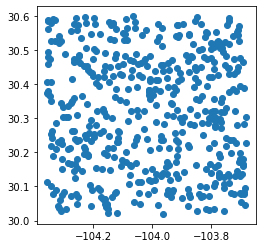

In [2]:
from shapely.geometry import Point
import numpy as np
import random
import folium
import geopandas as gpd
import h3

# Define the range for production
start = 0
stop = 100

# Define the bounding box for 
minx, miny = -103.6806, 30.0195
maxx, maxy = -104.3606, 30.5995

# Calculate the center latitude and longitude
center_lat = (miny + maxy) / 2
center_long = (minx + maxx) / 2

# Generate a list of random lat-long points within the bounding box
points = [Point(random.uniform(minx, maxx), random.uniform(miny, maxy)) for _ in np.arange(500)]

# Create a GeoDataFrame with the specified columns and attributes
gdf = gpd.GeoDataFrame({'production_rate': [random.randint(start, stop) for _ in np.arange(500)],
                        'geometry': points}, crs='EPSG:4326')

# Plot the GeoDataFrame
gdf.plot()



In [4]:
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

def split_rectangle(minx, miny, maxx, maxy, n):
    # Calculate total width and height
    width_total = maxx - minx
    height_total = maxy - miny

    # Determine dimensions for each rectangle
    width_divided = width_total / math.ceil(math.sqrt(n))
    height_divided = height_total / math.ceil(math.sqrt(n))

    # Generate rectangles
    rectangles = []
    lease_ids = []
    for i in range(math.ceil(math.sqrt(n))):
        for j in range(math.ceil(math.sqrt(n))):
            rect_minx = minx + i * width_divided
            rect_miny = miny + j * height_divided
            rect_maxx = rect_minx + width_divided
            rect_maxy = rect_miny + height_divided
            rect_polygon = Polygon([(rect_minx, rect_miny), (rect_maxx, rect_miny),
                                    (rect_maxx, rect_maxy), (rect_minx, rect_maxy)])
            rectangles.append(rect_polygon)
            lease_ids.append(f"lease_{i}_{j}")  # Generating lease IDs

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=rectangles, crs="EPSG:4326")

    # Generate random integers (1, 2, 3, or 4) for each row for 4 different owners
    gdf['owner'] = np.random.randint(1, 5, size=len(gdf))

    # Map the random integers to 'xyz', 'abc', 'def', or 'ghi' for each owner
    gdf['owner'] = gdf['owner'].map({1: 'xyz', 2: 'abc', 3: 'def', 4: 'ghi'})

    # Add lease ID column
    gdf['lease_id'] = lease_ids

    return gdf


minx, miny = -103.6806, 30.0195
maxx, maxy = -104.3606, 30.5995
n_rectangles = 100  # You can adjust this value

resulting_gdf = split_rectangle(minx, miny, maxx, maxy, n_rectangles)

# Print the first few rows of the resulting GeoDataFrame
print(resulting_gdf.head())


                                            geometry owner   lease_id
0  POLYGON ((-103.68060 30.01950, -103.74860 30.0...   xyz  lease_0_0
1  POLYGON ((-103.68060 30.07750, -103.74860 30.0...   def  lease_0_1
2  POLYGON ((-103.68060 30.13550, -103.74860 30.1...   abc  lease_0_2
3  POLYGON ((-103.68060 30.19350, -103.74860 30.1...   def  lease_0_3
4  POLYGON ((-103.68060 30.25150, -103.74860 30.2...   def  lease_0_4


In [5]:
import folium
from folium.plugins import FastMarkerCluster
from shapely.geometry import mapping

# Create a folium map centered at the mean of your GeoDataFrame's coordinates
m = folium.Map(location=[resulting_gdf['geometry'].centroid.y.mean(), resulting_gdf['geometry'].centroid.x.mean()], zoom_start=10)

# Convert the GeoDataFrame to GeoJSON
resulting_gdf_json = resulting_gdf.to_crs(epsg='4326').to_json()

# Add the GeoJSON data to the map
folium.GeoJson(resulting_gdf_json).add_to(m)

# Add a FastMarkerCluster layer for improved performance with large datasets
FastMarkerCluster(data=resulting_gdf['geometry'].apply(lambda geom: [geom.centroid.y, geom.centroid.x])).add_to(m)

# Display the map
m

<ipython-input-5-ea8186298ce7>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[resulting_gdf['geometry'].centroid.y.mean(), resulting_gdf['geometry'].centroid.x.mean()], zoom_start=10)


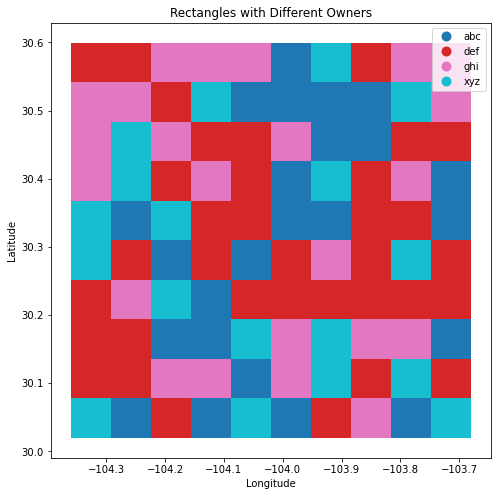

In [6]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame
resulting_gdf.plot(column='owner', legend=True, figsize=(10, 8))

# Add title and labels
plt.title('Rectangles with Different Owners')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [7]:
# Initialize the map
m = folium.Map(location=[center_lat, center_long], zoom_start=10)

# Add the rectangles with different owners
for _, row in resulting_gdf.iterrows():
    folium.Rectangle(bounds=[[row.geometry.bounds[1], row.geometry.bounds[0]], [row.geometry.bounds[3], row.geometry.bounds[2]]],
                     color=row['owner'], fill_color=row['owner'], fill_opacity=0.4).add_to(m)

# Add points to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=3, color='blue', fill=True, fill_color='blue').add_to(m)

# Display the map
m

In [67]:

print(gdf.head())

   production_rate                     geometry
0               53  POINT (-104.02496 30.29328)
1               40  POINT (-103.68461 30.52109)
2               35  POINT (-103.96855 30.49877)
3               11  POINT (-103.96430 30.46322)
4               27  POINT (-103.96353 30.48355)


In [69]:

print(resulting_gdf.head())

                                            geometry owner   lease_id  \
0  POLYGON ((-103.68060 30.01950, -103.74860 30.0...   def  lease_0_0   
1  POLYGON ((-103.68060 30.07750, -103.74860 30.0...   ghi  lease_0_1   
2  POLYGON ((-103.68060 30.13550, -103.74860 30.1...   abc  lease_0_2   
3  POLYGON ((-103.68060 30.19350, -103.74860 30.1...   ghi  lease_0_3   
4  POLYGON ((-103.68060 30.25150, -103.74860 30.2...   abc  lease_0_4   

   total_production  
0              6975  
1              7781  
2              3822  
3              7781  
4              3822  


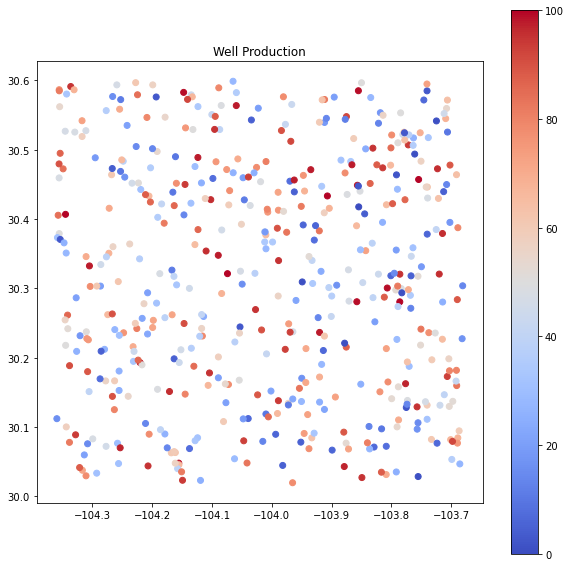

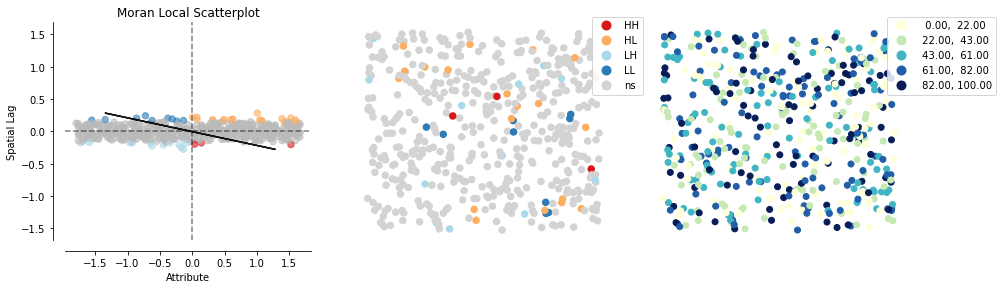

In [9]:
import geopandas as gpd
import libpysal.weights as weights
from esda.moran import Moran, Moran_Local
from splot.esda import plot_local_autocorrelation
import matplotlib.pyplot as plt

# Assuming 'gdf' is your GeoDataFrame containing production rate and geometry
# Replace 'gdf' with the actual variable name

# Compute spatial weights
k = min(5, len(gdf) - 1)
w = weights.KNN.from_dataframe(gdf, k=k)

# Spatial Autocorrelation Analysis
moran = Moran(gdf['production_rate'], w)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='production_rate', cmap='coolwarm', legend=True, ax=ax)
plt.title('Well Production')
plt.show()

# Visualize Local Moran's I
local_moran = Moran_Local(gdf['production_rate'], w)
plot_local_autocorrelation(local_moran, gdf, 'production_rate')
plt.show()


C:\Users\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


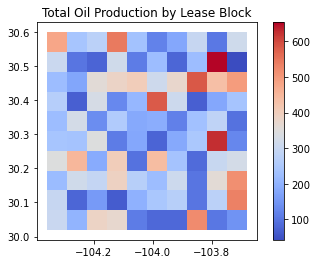

Lease block with the most oil production (Owner, Cell ID): ('xyz', 'lease_1_8')
Owner with the most oil production: def


In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Perform spatial join between lease blocks and oil well points
joined_data = gpd.sjoin(gdf, resulting_gdf, op='within')

# Aggregate production by lease block
lease_production = joined_data.groupby(['owner', 'lease_id'])['production_rate'].sum()

# Find lease block with maximum production
max_production_lease = lease_production.idxmax()

# Visualize lease blocks with production rates
resulting_gdf['total_production'] = resulting_gdf.apply(lambda row: lease_production.get((row['owner'], row['lease_id']), 0), axis=1)
resulting_gdf.plot(column='total_production', cmap='coolwarm', legend=True)
plt.title('Total Oil Production by Lease Block')
plt.show()

# Find owner with maximum production
max_production_owner = lease_production.groupby('owner').sum().idxmax()

print("Lease block with the most oil production (Owner, Cell ID):", max_production_lease)
print("Owner with the most oil production:", max_production_owner)





In [ ]:
# Step 3: Aggregate Production by Lease
# Spatial index for leases
lease_sindex = lease_gdf.sindex

# Spatial join points with leases using spatial index
points_with_lease = gpd.sjoin(points_gdf, lease_gdf, op='within', how='left')




In [ ]:
# Step 4: Calculate Production per Lease
# Group by lease ID and sum production rate
production_per_lease = points_with_lease.groupby('lease_id')['production_rate'].sum()

# Step 5: Identify Lease Owner with the Most Production
lease_owner_with_most_production = production_per_lease.idxmax()

print("Lease owner with the most production:", lease_owner_with_most_production)

C:\Users\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


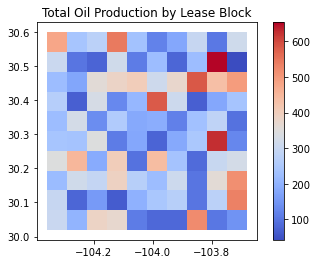

Lease block with the most oil production (Owner, Lease ID): ('xyz', 'lease_1_8')
Owner with the most oil production: def


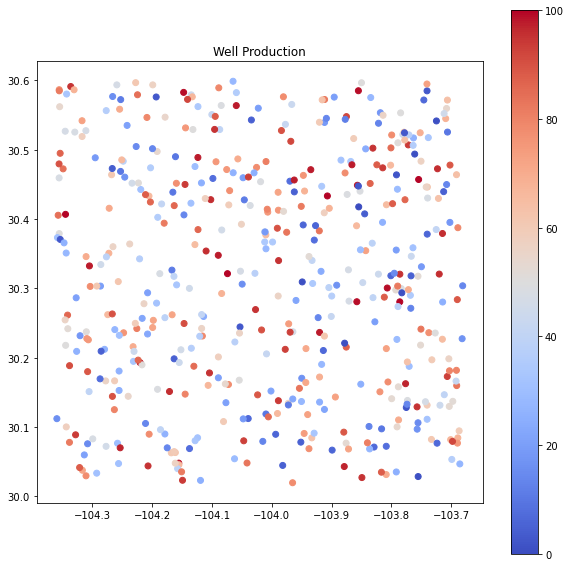

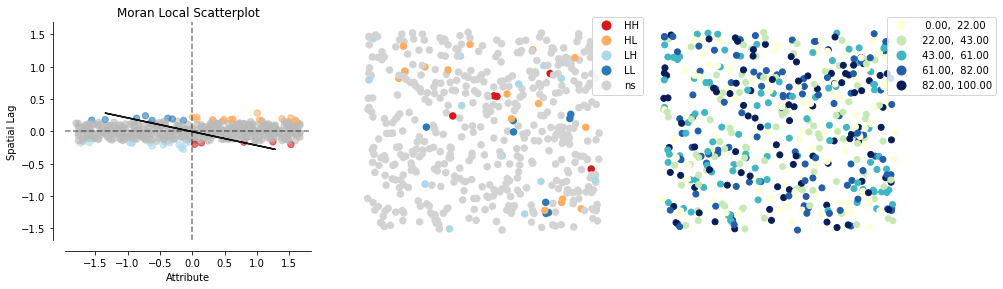

In [13]:
import geopandas as gpd
import libpysal.weights as weights
from esda.moran import Moran, Moran_Local
from splot.esda import plot_local_autocorrelation
import matplotlib.pyplot as plt

# Perform spatial join between lease blocks and oil well points
joined_data = gpd.sjoin(gdf, resulting_gdf, op='within')

# Aggregate production by lease block
lease_production = joined_data.groupby(['owner', 'lease_id'])['production_rate'].sum()

# Find lease block with maximum production
max_production_lease = lease_production.idxmax()

# Visualize lease blocks with production rates
resulting_gdf['total_production'] = resulting_gdf.apply(lambda row: lease_production.get((row['owner'], row['lease_id']), 0), axis=1)
resulting_gdf.plot(column='total_production', cmap='coolwarm', legend=True)
plt.title('Total Oil Production by Lease Block')
plt.show()

# Find owner with maximum production
max_production_owner = lease_production.groupby('owner').sum().idxmax()

print("Lease block with the most oil production (Owner, Lease ID):", max_production_lease)
print("Owner with the most oil production:", max_production_owner)

# Compute spatial weights
k = min(5, len(gdf) - 1)
w = weights.KNN.from_dataframe(gdf, k=k)

# Spatial Autocorrelation Analysis
moran = Moran(gdf['production_rate'], w)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='production_rate', cmap='coolwarm', legend=True, ax=ax)
plt.title('Well Production')
plt.show()

# Visualize Local Moran's I
local_moran = Moran_Local(gdf['production_rate'], w)
plot_local_autocorrelation(local_moran, gdf, 'production_rate')
plt.show()
